<div style="text-align: center;" >
<h1 style="margin-top: 0.2em; margin-bottom: 0.1em;">Assignment 5</h1>
</div>
<br>

## Social Network Analysis of Swiss Politicians on Twitter Data (Part 2)
In the first part of this assignment you will do the following tasks:
1. Load social network of retweets
2. Calculate assortativity
3. Permutation tests
4. Community detection

### Install requirements. 

The following cell contains all the necessary dependencies needed for this task. If you run the cell everything will be installed.  

* [`pandas`](https://pandas.pydata.org/docs/index.html) is a Python package for creating and working with tabular data. [Here](https://pandas.pydata.org/docs/reference/index.html) is the documentation of `pandas`.
* [`numpy`](https://numpy.org/) is a Python package for mathematical functions. [Here](https://numpy.org/doc/stable/reference/index.html) is the documentation of `numpy`.
* [`matplotlib`](https://matplotlib.org/) is a Python package for creating plots. [Here](https://matplotlib.org/stable/api/index.html) is the documentation of `matplotlib`.
* [`networkx`](https://networkx.org/) is a Python package for the creation, manipulation, and study of the structure, dynamics, and functions of complex networks. [Here](https://networkx.org/documentation/stable/reference/index.html) is the documentation of `networkx`.

In [1]:
! pip install pandas
! pip install numpy
! pip install matplotlib
! pip install networkx

### Import requirements
The cell below imports all necessary dependancies. Make sure they are installed (see cell above).

In [2]:
import pandas as pd
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

### Exercise 1: Load social networks of retweets

The attached `sec` file contains an undirected retweet network of Swiss politicians for the time between 2021-07-12 and 2022-07-12. Each node in the network is a represents a politician, and stores their Twitter user id, username, and party affiliation. An edge exists between a pair of politicians that exchanged at least one retweet with each other (regardless of the direction). You can load the file using `nx.read_gexf()`

* How many nodes and edges are there in the network?



In [158]:
network = nx.read_gexf("swiss_pol_retweet_networkgexf.sec")

In [159]:
print("Number of nodes: ", network.number_of_nodes())
print("Number of edges: ", network.number_of_edges())

Number of nodes:  334
Number of edges:  471


### Exercise 2: Calculate graph assortativity

Use the function [`attribute_assortativity_coefficient`](https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.assortativity.attribute_assortativity_coefficient.html) of `networkx` to calculate the assortativity with respect to party labels. How high is the value?

In [160]:
assortativity = nx.attribute_assortativity_coefficient(network, "party")
print(f"assortativity: {assortativity:05f}")

assortativity: 0.531500


To see if the assortativity value fits your expectations, use the function [`draw_networkx`](https://networkx.org/documentation/stable/reference/generated/networkx.drawing.nx_pylab.draw_networkx.html) to plot the network coloring each node according to the political party label of the politician. Does the pattern of colors fit the value of assortativity?

In [161]:
nodes = network.nodes()
parties = [nx.get_node_attributes(network,'party').get(node) for node in nodes]
unique_parties = set(parties)

In [162]:
cmap = plt.get_cmap("Set3")
colors = [cmap(i) for i in range(len(unique_parties))]
color_dict = {party:color for party, color in zip(unique_parties, colors)}
node_colors = [color_dict[party] for party in parties]

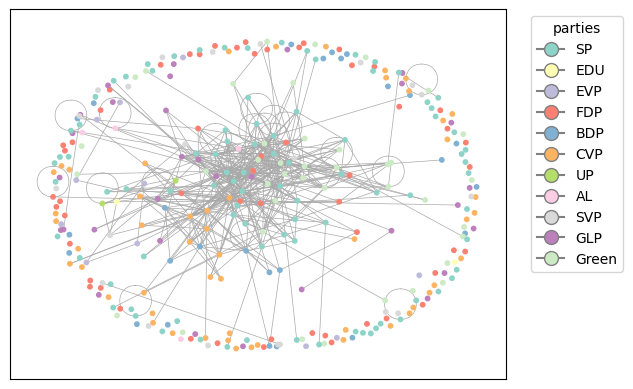

In [163]:
fig, ax = plt.subplots()
position=nx.spring_layout(network, k=0.8, iterations=90)
nx.draw_networkx(
    network,
    pos=position, 
    nodelist=nodes,
    node_color=node_colors,
    node_size=10,
    edge_color="darkgrey",
    width=0.5,
    with_labels=False,
    ax=ax
)
# let's add a legend! Since draw_network does not do this automatically, we have
# to create custom legend elements to add to the plot
from matplotlib.lines import Line2D
legend_elements = [Line2D([0], [0], marker='o', color="grey", label=key,
        markerfacecolor=val, markersize=10) for key, val in color_dict.items()]
ax.legend(
    handles=legend_elements, # customly made legend handles
    title="parties", # title of the legend
    loc=1, # anchors the legend in the upper right corner
    bbox_to_anchor=[1.25, 1, 0, 0] # puts the legend outside the plot
);

### Exercise 3: Permutation tests 

The above result looks assortative, but how can we test if it could have happened at random and not because of party identity? Here were are going to test it with a permutation test.

First, let's run a permutation. Perform the same assortativity calculation as above but permuting the party labels of nodes. 

Also set the party for each node as node attribute by using [`set_node_attribute`](https://networkx.org/documentation/stable/reference/generated/networkx.classes.function.set_node_attributes.html) (be carefull the parties are now permuted).

In [164]:
import random

In [165]:
df = pd.DataFrame.from_dict(dict(network.nodes(data=True)), orient='index')
df = df.rename(columns={"label": "id"})
df.reset_index(inplace=True, drop=True)

In [166]:
parties_shuffled = random.sample(parties, len(parties))
shuffled_labels = {node:party for node, party in zip(nodes, parties_shuffled)}
nx.set_node_attributes(network, shuffled_labels, name="party")

In [167]:
nx.attribute_assortativity_coefficient(network, "party")

0.007833687447098808

Is the value much closer to zero?
Repeat the calculation with 1000 permutations and plot the histogram of the resulting values. Add a line with the value of the assortativity without permutation. Is it far or close to the permuted values?

In [168]:
def calculate_shuffled_assortativity(G, df):
    parties_shuffled = df.sample(frac=1)["party"].values
    shuffled_labels = {node:party for node, party in zip(df['id'], parties_shuffled)}
    nx.set_node_attributes(G, shuffled_labels, name="party")
    return nx.attribute_assortativity_coefficient(G, "party")

In [169]:
perm_assortativities = [calculate_shuffled_assortativity(network, df) \
                   for _ in range(1000)]

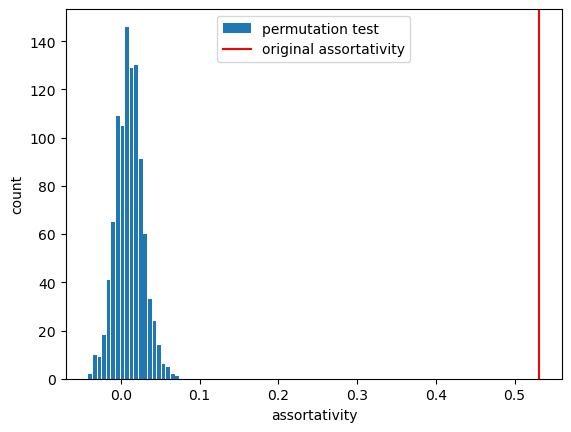

In [170]:
fig, ax = plt.subplots()
ax.hist(perm_assortativities, rwidth=0.8, label="permutation test", bins=20)
ax.axvline(assortativity, color="red", label="original assortativity")
ax.set_ylabel("count")
ax.set_xlabel("assortativity")
ax.legend(loc=9);

To be sure, let's calculate a p-value for the null hypothesis that the assortativity is zero and the alternative hypothesis that it is positive (what we expected):

In [171]:
perm_assortativities = np.asarray(perm_assortativities)
(1 + sum(perm_assortativities > assortativity)) / len(perm_assortativities)

0.001

After looking at the above results, do you think it is likely that the assortativity we found in the data was produced by chance?

### Exercise 4: Community detection 

Let's test if Twitter communities match political affiliations. Remove nodes with degree zero in the network and run the [Louvain community detection algorithm](https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.community.louvain.louvain_communities.html). Visualize the result coloring nodes by community labels.

In [172]:
import networkx.algorithms.community as nx_comm

In [173]:
G = nx.read_gexf("swiss_pol_retweet_networkgexf.sec")
G.remove_nodes_from(list(nx.isolates(G)))

In [174]:
communities = nx_comm.louvain_communities(G)

In [175]:
# Some coloring
N_communities = len(communities)
cmap = plt.get_cmap("tab20")
colors = [cmap(i) for i in range(N_communities)]
color_dict = {community:color for community, color in zip(range(N_communities), colors)}

node_list = []
node_colors = []
for i, community in enumerate(communities):
    for node in community:
        node_list.append(node)
        node_colors.append(color_dict[i])

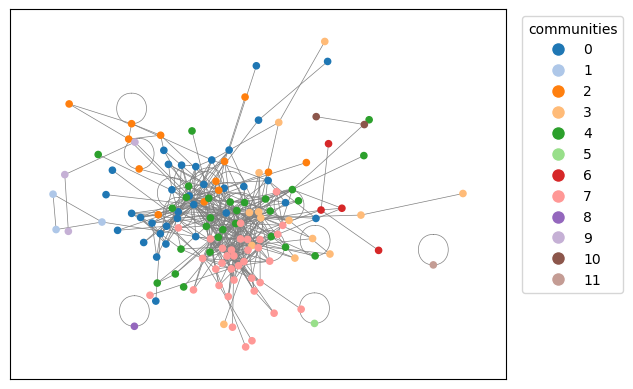

In [176]:
fig, ax = plt.subplots()
position=nx.spring_layout(network, k=0.5, iterations=90)
nx.draw_networkx(
    G, 
    pos=position,
    nodelist=node_list,
    node_color=node_colors,
    node_size=20, 
    with_labels=False,
    edge_color="gray",
    width=0.5,
    ax=ax
)

# add a legend
legend_elements = [Line2D([0], [0], marker='o', color="w", label=key,
                          markerfacecolor=val, markersize=10) for key, val in color_dict.items()]
ax.legend(
    handles=legend_elements,
    title="communities",
    loc=1, 
    bbox_to_anchor=[1.25, 1, 0, 0]
);

Run the [`modularity`](https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.community.quality.modularity.html) function with the above community labels. Is it high enough to think that the network has a community structure?

In [177]:
nx_comm.modularity(G, communities)

0.5060290929088852

Repeat but using the party labels instead of the communities detected with Louvain. Is it higher or lower? How far is this modularity from the maximal one found with Louvain?

For this iterate over the parties and filter a subset of users that is in the given party and in the graph. Add the ids of these partymembers (do not include any duplicates) and repeat this for all parties.

Afterwards you can calculate the modularity.

In [179]:
# update df
df = pd.DataFrame.from_dict(dict(G.nodes(data=True)), orient='index')
df = df.rename(columns={"label": "id"})
df.reset_index(inplace=True, drop=True)

In [180]:
parties = df["party"].unique()
party_communities = []
for party in parties:
    # filter a subset of users that is in the given party and in the graph
    party_members = df[(df["party"] == party)]
    party_communities.append(set(party_members["id"].values))

In [181]:
nx_comm.modularity(G, party_communities)

0.42083519277320236

Finally, to understand which parties are represented in each community, build a data frame for nodes with two columns: one with the party label and another one with the community label. Use the [`groupby()`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.groupby.html) function to print a contingency table. Which party or parties compose each community?

In [182]:
# create a copy of the user data frame with all users that are also in the graph
user_communities = df[["id", "party"]].copy()
user_communities = user_communities.set_index("id")
user_communities["community"] = -1
for i, community in enumerate(communities):
    user_communities.loc[list(community), "community"] = i
user_communities = user_communities\
    .reset_index()\
    .sort_values(by="party")

In [183]:
user_communities\
    .groupby(["party", "community"])\
    .count()\
    .rename(columns={"id":"count"})

count
party community       
AL    4              2
BDP   0              7
      2              1
      3              1
      7              1
CVP   0             15
      6              1
EDU   2              1
EVP   0              2
      1              3
FDP   0              6
      2              5
GLP   2              1
      3             13
Green 4             24
      9              1
SP    0              1
      2              2
      4              2
      5              1
      6              3
      7             34
      8              1
      9              2
SVP   0              3
      2              1
      10             2
      11             1
UP    2              2

### Exercise 5: Prediction and discussion of other methods
* How well can you predict the party of a politician from its neighbors in the network? Here you can use the rule of predicting the party as the majority party among its neighbors and evaluate the accuracy of this approach.
* What would be the results if we use the network of replies? Do you expect assortativity and modularity to be higher or lower?
* If you retrieved data of follower links, you can repeat the above analysis for undirected following relationships. Do you expect a higher or lower assortativity?